In [132]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [133]:
df = pd.read_excel("Online Retail.xlsx")

# Data Preprocessing

In [134]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [135]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [136]:
df = df.drop(["Description"],axis=1)

In [137]:
df = df.dropna()

In [138]:
df.isnull().sum()

InvoiceNo      0
StockCode      0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

<AxesSubplot:>

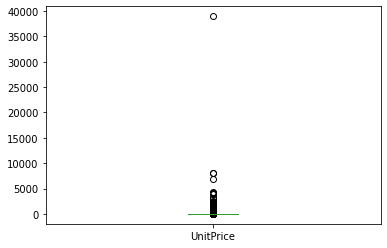

In [139]:
df["UnitPrice"].plot(kind="box")

In [140]:
df_sorted = df[df["Quantity"]!=-1].sort_values(by=["UnitPrice"], ascending=False)

In [141]:
len(df_sorted[df_sorted["UnitPrice"]>1000])

22

In [142]:
df = df_sorted[df_sorted["UnitPrice"]<1000][df_sorted["Quantity"]>0][df["UnitPrice"]>0]

C:\Users\nehue\AppData\Local\Temp\ipykernel_17908\41533685.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df_sorted[df_sorted["UnitPrice"]<1000][df_sorted["Quantity"]>0][df["UnitPrice"]>0]


In [143]:
import re

In [144]:
stc = df["StockCode"].unique()

stock_with_words = [stockcode for stockcode in stc if type(stockcode)!=int]
stock_with_words = [sc for sc in stock_with_words if not any(char.isdigit() for char in sc)]

In [145]:
stock_with_words

['DOT', 'M', 'POST', 'BANK CHARGES', 'PADS']

In [146]:
for word in stock_with_words:

    df = df[df["StockCode"]!=word]

<AxesSubplot:>

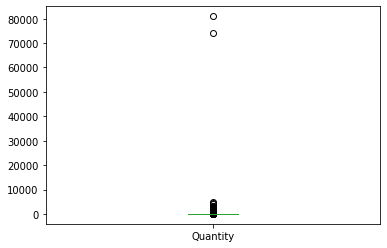

In [147]:
df["Quantity"].plot(kind="box")

In [148]:
df[df["Quantity"]>10000]

,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
540421,581483,23843,80995,2011-12-09 09:15:00,2.08,16446.0,United Kingdom
61619,541431,23166,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom


In [149]:
df = df[df["Quantity"]<3000]


# Feature selection and engineering

- Create more features (based on each customer): average_purchase_quantity, average_purchase_expense, Purchase_frequency, time_as_buyer, lifetime_expenses, unique_items_bought

- Encode categorical features: Country



In [150]:
# average_purchase_quantity

df['average_purchase_quantity'] = df.groupby('CustomerID')['UnitPrice'].transform('mean')

In [151]:
# average_purchase_expense

df['average_purchase_expense'] = df.groupby('CustomerID')['Quantity'].transform('mean')

In [152]:
# Purchase_frequency

purchase_dates = df.groupby('CustomerID')['InvoiceDate'].agg(['min', 'max', "count"])

purchase_dates['Purchase_frequency'] = (purchase_dates['max'] - purchase_dates['min']).dt.days / purchase_dates["count"]

df = pd.merge(df, purchase_dates['Purchase_frequency'], on='CustomerID')

In [153]:
# time_as_buyer

purchase_dates = df.groupby('CustomerID')['InvoiceDate'].agg(['min', 'max'])

purchase_dates['time_as_buyer'] = (purchase_dates['max'] - purchase_dates['min']).dt.days

df = pd.merge(df, purchase_dates['time_as_buyer'], on='CustomerID')

In [154]:
# lifetime_expenses

df["lifetime_expenses"] = df.groupby('CustomerID')['UnitPrice'].transform('sum')

In [155]:
# unique_items_bought

unique = df.groupby('CustomerID')['StockCode'].nunique()

unique_df = unique.to_frame()

df = pd.merge(df, unique_df, on='CustomerID')

df["unique_items_bought"] = df["StockCode_y"]

df = df.drop(columns="StockCode_y")
df = df.drop(columns="StockCode_x")

In [156]:
df = pd.get_dummies(df, columns=['Country'])

In [157]:
df.columns

Index(['InvoiceNo', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID',
       'average_purchase_quantity', 'average_purchase_expense',
       'Purchase_frequency', 'time_as_buyer', 'lifetime_expenses',
       'unique_items_bought', 'Country_Australia', 'Country_Austria',
       'Country_Bahrain', 'Country_Belgium', 'Country_Brazil',
       'Country_Canada', 'Country_Channel Islands', 'Country_Cyprus',
       'Country_Czech Republic', 'Country_Denmark', 'Country_EIRE',
       'Country_European Community', 'Country_Finland', 'Country_France',
       'Country_Germany', 'Country_Greece', 'Country_Iceland',
       'Country_Israel', 'Country_Italy', 'Country_Japan', 'Country_Lebanon',
       'Country_Lithuania', 'Country_Malta', 'Country_Netherlands',
       'Country_Norway', 'Country_Poland', 'Country_Portugal', 'Country_RSA',
       'Country_Saudi Arabia', 'Country_Singapore', 'Country_Spain',
       'Country_Sweden', 'Country_Switzerland', 'Country_USA',
       'Country_United Arab Emi

In [158]:
# Converting to a customer based dataframe and leaving out unecessary features:

df.drop(columns=["InvoiceNo", "Quantity", "InvoiceDate","UnitPrice"], inplace=True)

df = df.groupby('CustomerID').apply(pd.DataFrame).reset_index().drop_duplicates()

df.drop(columns=["CustomerID"], inplace=True)

C:\Users\nehue\AppData\Local\Temp\ipykernel_17908\475855175.py:5: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df = df.groupby('CustomerID').apply(pd.DataFrame).reset_index().drop_duplicates()


In [162]:
df.drop(columns=["index"], inplace=True)
df.drop_duplicates()

,average_purchase_quantity,average_purchase_expense,Purchase_frequency,time_as_buyer,lifetime_expenses,unique_items_bought,Country_Australia,Country_Austria,Country_Bahrain,Country_Belgium,...,Country_RSA,Country_Saudi Arabia,Country_Singapore,Country_Spain,Country_Sweden,Country_Switzerland,Country_USA,Country_United Arab Emirates,Country_United Kingdom,Country_Unspecified
0,434.650000,40.333333,0.000000,0,1303.95,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,5.326276,8.041379,1.820690,264,772.31,128,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
148,295.000000,1.000000,5.500000,11,590.00,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
150,5.035568,9.187500,1.107955,195,886.26,156,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
326,4.347849,16.622093,1.982558,341,747.83,140,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396451,0.290000,40.000000,0.000000,0,0.87,3,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
396454,0.290000,312.000000,0.000000,0,0.29,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
396455,0.143333,1280.000000,74.666667,224,0.43,2,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
396458,0.170000,1009.500000,109.500000,219,0.34,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


# Feature scaling

In [160]:
from sklearn.preprocessing import StandardScaler

In [161]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)